In [89]:
# Import necessary modules for TARDIS High Energy Workflow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u

from tardis.io.atom_data import AtomData, download_atom_data
from tardis.io.configuration.config_reader import Configuration
from tardis.workflows.high_energy.tardis_he_workflow import TARDISHEWorkflow

# Configure matplotlib for LaTeX rendering of scientific notation and Greek letters
plt.rcParams['text.usetex'] = False  # Use mathtext instead of full LaTeX for better compatibility
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'  # Computer Modern fonts for consistency

# TARDIS High Energy Workflow Tutorial

This notebook demonstrates how to use the TARDIS High Energy (HE) Workflow to simulate gamma-ray transport in supernova ejecta. The HE workflow is specifically designed to model high-energy phenomena in supernovae, including:

- Gamma-ray transport through the ejecta
- Energy deposition processes
- Positron-electron pair creation
- Compton scattering
- Photoabsorption processes

In this example, we'll simulate a **white dwarf merger scenario for Type Ia supernovae** based on the HESMA (Heidelberg Supernova Model Archive) dataset and the model from **Pakmor et al. (2012)**. This represents a double-detonation scenario where gamma-rays from radioactive decay (primarily ⁵⁶Ni → ⁵⁶Co → ⁵⁶Fe) play a crucial role in powering the optical light curve.

This tutorial is based on the methodology and results presented in **Dutta et al. (2025)**, which demonstrates the application of the TARDIS HE workflow to Type Ia supernova models and provides detailed analysis of gamma-ray transport in these systems.

In [90]:
# Download and load atomic data
# We recommend using the latest atomic data from the TARDIS data repository
atomic_data_fname = "kurucz_cd23_chianti_H_He_latest"
download_atom_data(atomic_data_fname)
atom_data = AtomData.from_hdf("kurucz_cd23_chianti_H_He_latest.h5")

INFO:tardis.io.atom_data.util:
	Atom Data kurucz_cd23_chianti_H_He_latest.h5 not found in local path.
	Exists in TARDIS Data repo /Users/wkerzend/projects/tardis/tardis-data/kurucz_cd23_chianti_H_He_latest.h5
INFO:tardis.io.atom_data.util:
	Atom Data kurucz_cd23_chianti_H_He_latest.h5 not found in local path.
	Exists in TARDIS Data repo /Users/wkerzend/projects/tardis/tardis-data/kurucz_cd23_chianti_H_He_latest.h5
INFO:tardis.io.atom_data.base:Reading Atom Data with: UUID = b58b2ef63bf811f08edf96479f911fbd MD5  = 5d80fa4ae0638469bf1ff281b6ca2a94 
INFO:tardis.io.atom_data.base:Non provided Atomic Data: levels, lines, collision_data, collision_data_temperatures, synpp_refs, photoionization_data, yg_data, two_photon_data, linelist_atoms, linelist_molecules
INFO:tardis.io.atom_data.base:Reading Atom Data with: UUID = b58b2ef63bf811f08edf96479f911fbd MD5  = 5d80fa4ae0638469bf1ff281b6ca2a94 
INFO:tardis.io.atom_data.base:Non provided Atomic Data: levels, lines, collision_data, collision_data

In [91]:
# Load the HESMA white dwarf merger configuration (Pakmor et al. 2012)
# This configuration represents a Type Ia supernova from a double-detonation scenario

config_file = "tardis_config_merger_2012.yml"
config = Configuration.from_yaml(config_file)

In [92]:
# Initialize the TARDIS High Energy Workflow
he_workflow = TARDISHEWorkflow(
    atom_data=atom_data, configuration=config, config_type="csvy"
)

INFO:tardis.model.matter.decay:Decaying abundances for 2600540.0352 seconds
INFO:tardis.model.matter.decay:Decaying abundances for 2600540.0352 seconds


In [93]:
# Run the High Energy simulation for Type Ia supernova
# These parameters are optimized for white dwarf merger gamma-ray transport

simulation_params = {
    "time_start": 2.0,  # Start time in days (early in SN evolution)
    "time_end": 100.0,  # End time in days (covers main decay period)
    "number_of_packets": int(
        1e6
    ),  # Number of gamma-ray packets (for quick demo)
    "time_steps": 500,  # Number of time steps
    "time_space": "log",  # Logarithmic time spacing (appropriate for decay)
    "seed": 1993,  # Random seed for reproducibility
    "fp": 0.0,  # Covering factor
    "spectrum_bins": 300,  # Number of spectrum bins
    "grey_opacity": -1,  # Use detailed opacity calculation
    "legacy": True,
    "legacy_atom_data": atom_data,  # Use legacy mode for compatibility
}

# Run the simulation (commented out for demo - use pre-computed results)
#he_result = he_workflow.run(**simulation_params)

## TARDIS vs HESMA Comparison

This section compares TARDIS HE results with the HESMA (Heidelberg Supernova Model Archive) reference model from Pakmor et al. (2012). 

### Data Extraction Options

The TARDIS HE workflow provides two ways to access the gamma-ray spectra:

1. **Direct extraction** from the simulation result object (`he_result.escaped_energy_spectrum`)
2. **Loading from disk** using pre-computed high-statistics results

For this tutorial, we use pre-computed results with 5×10⁷ packets to ensure:
- **High signal-to-noise ratio** for clear spectral features
- **Faster execution** without waiting for long simulations
- **Reproducible results** for documentation purposes

In [ ]:
# Extract spectrum from simulation result (commented out - using pre-computed data)
# If you ran the simulation above, you could extract the spectrum directly:

# # Option 1: Extract from simulation result
tardis_luminosity_density = he_result.escape_energy  # Gamma-ray energy spectrum data
# print("Escape energy shape:", tardis_luminosity_density.shape)
# print("Escape energy units:", tardis_luminosity_density.unit)

# Convert TARDIS luminosity density to flux at 10 pc for comparison with HESMA
distance = 10 * u.pc
flux_conversion = 1 / (4 * np.pi * distance**2)

# Convert entire TARDIS dataset to flux density (erg/cm²/s/Hz)
tardis_flux_density = tardis_luminosity_density * u.erg / u.s / u.Hz * flux_conversion
tardis_flux_density = tardis_flux_density.to(u.erg / u.cm**2 / u.s / u.Hz)

# The escape_energy contains the gamma-ray luminosity as a function of energy and time
# Shape: (n_energy_bins, n_time_steps) with units of erg/s/Hz
# After conversion: flux density in erg/cm²/s/Hz at 10 pc distance

# You would then need to extract the time grid from the simulation or workflow
# and assign proper units before proceeding with the analysis

# Option 2: Load pre-computed high-statistics results (5e7 packets)
# This provides better signal-to-noise ratio and faster execution
# tardis_flux_density = pd.read_csv("merger_2012_100d_500ts_5e7_escape_energy.csv", index_col=0)
# tardis_flux_density = tardis_flux_density * u.erg / u.s / u.Hz * flux_conversion
# tardis_flux_density = tardis_flux_density.to(u.erg / u.cm**2 / u.s / u.Hz)

# Load HESMA reference data - already in flux density units (erg/cm²/s/Hz)
hesma_flux_density = pd.read_csv("merger_2012_11_09_spectra_gamma.dat", sep=r'\s+')
hesma_flux_density.set_index(hesma_flux_density.columns[0], inplace=True)
hesma_flux_density = hesma_flux_density * u.erg / u.cm**2 / u.s / u.Hz

print(f"TARDIS flux density shape: {tardis_flux_density.shape}")
print(f"HESMA flux density shape: {hesma_flux_density.shape}")
print(f"TARDIS flux density units: {tardis_flux_density.unit}")
print(f"HESMA flux density units: {hesma_flux_density.unit}")

In [ ]:
# Extract times and convert to astropy units
tardis_times_explosion = tardis_flux_density.columns.values.astype(float) * u.s
tardis_times_explosion = tardis_times_explosion.to(u.day)
hesma_times_explosion = hesma_flux_density.columns.values.astype(float) * u.day

# Target times for comparison
target_times = [25, 50, 100] * u.day

# Find closest time indices, handling out-of-bounds cases
def get_closest_index(times, target):
    idx = times.searchsorted(target)
    return min(idx, len(times) - 1)

tardis_indices = [get_closest_index(tardis_times_explosion, t) for t in target_times]
hesma_indices = [get_closest_index(hesma_times_explosion, t) for t in target_times]

# Extract data at target times
tardis_times = [tardis_times_explosion[i] for i in tardis_indices]
hesma_times = [hesma_times_explosion[i] for i in hesma_indices]

# Extract flux data at target times (already in flux units)
tardis_target_flux = [tardis_flux_density.iloc[:, i].values * tardis_flux_density.unit for i in tardis_indices]
hesma_target_fluxes = [hesma_flux_density.iloc[:, i].values * hesma_flux_density.unit for i in hesma_indices]

print(f"TARDIS times: {tardis_times[0]:.1f}, {tardis_times[1]:.1f}, {tardis_times[2]:.1f}")
print(f"HESMA times:  {hesma_times[0]:.1f}, {hesma_times[1]:.1f}, {hesma_times[2]:.1f}")
print(f"Units: TARDIS = {tardis_target_flux[0].unit}, HESMA = {hesma_target_fluxes[0].unit}")

# Both datasets are already in the same flux units
print(f"Data ready for comparison - both in flux density units: {tardis_target_flux[0].unit}")

TARDIS times: 25.0 d, 50.2 d, 99.2 d
HESMA times:  25.0 d, 50.4 d, 101.7 d
Units: TARDIS = erg / (Hz s pc2), HESMA = erg / (Hz s cm2)
Converted TARDIS units: erg / (Hz s cm2)


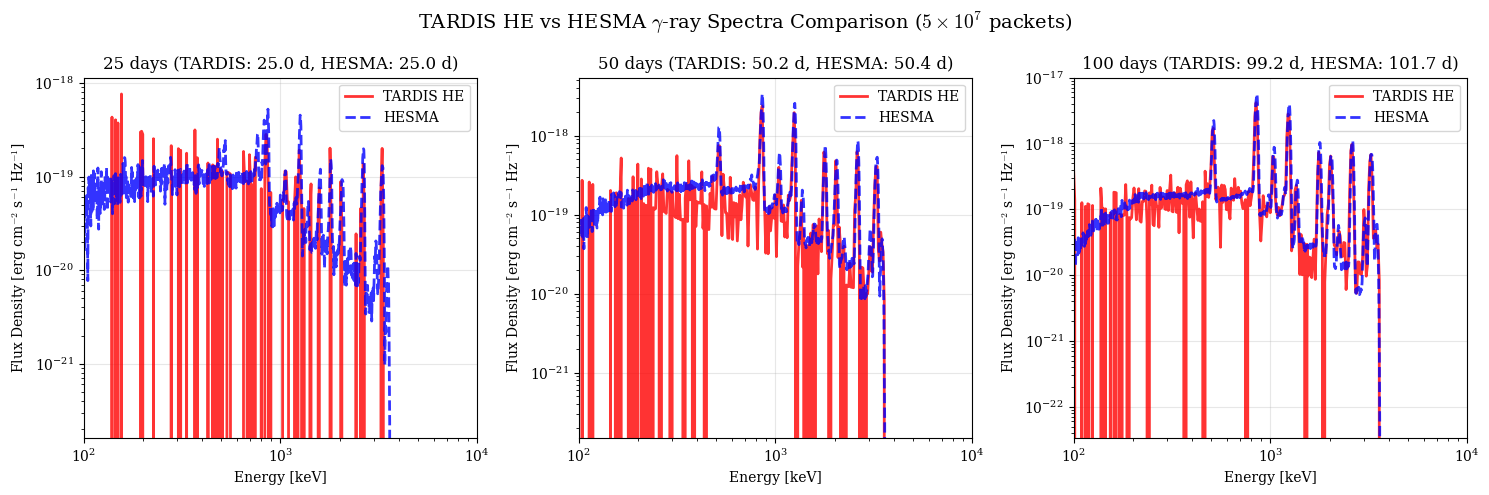

In [ ]:
# Extract energy arrays with units for each dataset
gamma_energies_tardis = tardis_flux_density.index.values * u.keV
gamma_energies_hesma = hesma_flux_density.index.values * u.MeV

# Create comparison plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(r'TARDIS HE vs HESMA $\gamma$-ray Spectra Comparison ($1 \times 10^6$ packets)', fontsize=14)

target_labels = [f'{t.value:.0f} days' for t in target_times]

for i, (ax, label) in enumerate(zip(axes, target_labels)):
    # Plot both spectra with their respective energy grids (both now in same flux units)
    ax.loglog(gamma_energies_tardis, tardis_target_flux[i], 'r-', label='TARDIS HE', linewidth=2, alpha=0.8)
    ax.loglog(gamma_energies_hesma.to(u.keV), hesma_target_fluxes[i], 'b--', label='HESMA', linewidth=2, alpha=0.8)
    
    ax.set_title(f'{label} (TARDIS: {tardis_times[i]:.1f}, HESMA: {hesma_times[i]:.1f})')
    ax.set_xlabel(f'Energy [{gamma_energies_tardis.unit}]')
    ax.set_ylabel(r'Flux Density [erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$]')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(100, 10000)  # Adjusted range for keV

plt.tight_layout()
plt.show()

/var/folders/fg/nwmb1mss6kq3hwhj10dt0qh00000gn/T/ipykernel_69146/3967224948.py:103: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(ymin, ymax)


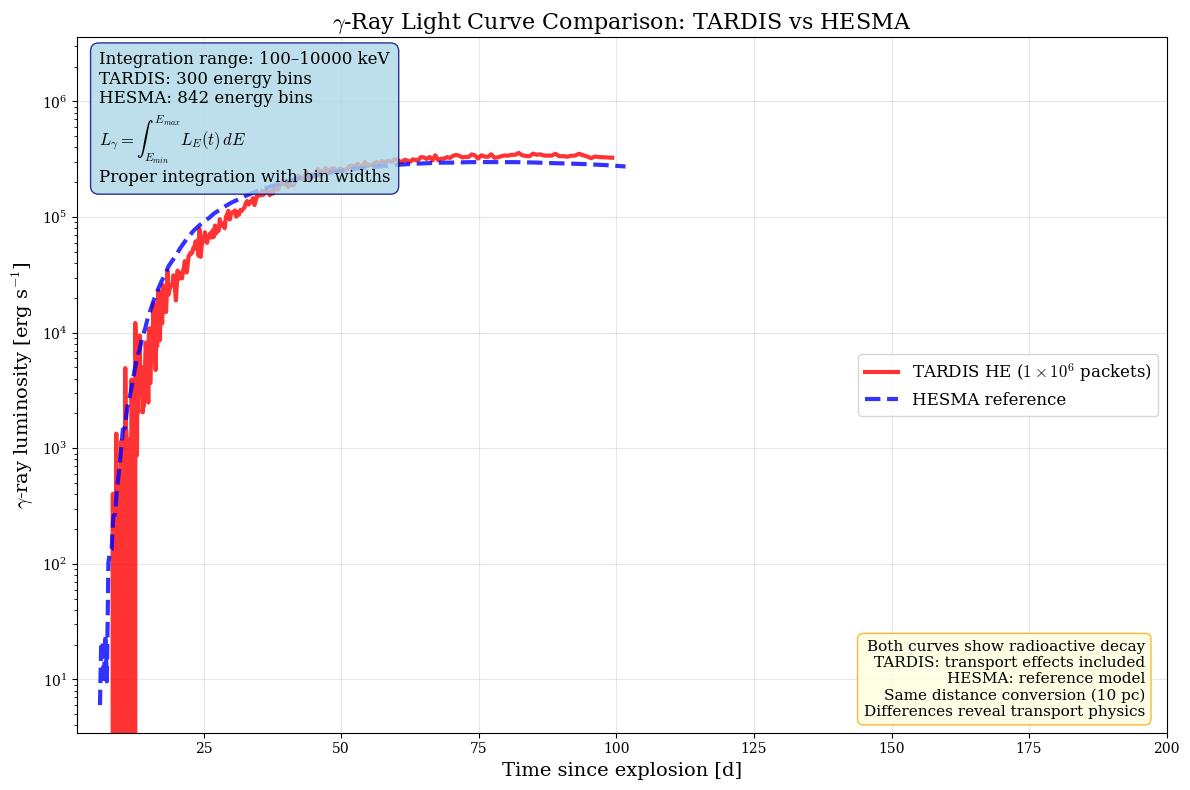

Integration range: 100.0 keV to 10000.0 keV
TARDIS energy bins used: 300 out of 300
HESMA energy bins used: 842 out of 1000
Peak TARDIS luminosity: 3.59e+05 pc2 erg / (Hz cm2 s2)
Peak HESMA luminosity: 2.99e+05 pc2 erg / (Hz cm2 s2)
Distance conversion: 10.0 pc -> flux conversion: 7.96e-04 1 / pc2
Luminosity conversion: 1.26e+03 pc2


In [ ]:
# Gamma-ray light curve comparison using proper integration
fig, ax = plt.subplots(figsize=(12, 8))

# Define energy integration range for gamma-ray light curves
energy_min = 100 * u.keV  # Minimum energy for integration
energy_max = 10000 * u.keV  # Maximum energy for integration

# Physical constants for energy-frequency conversion
h_planck = 4.136e-15 * u.eV * u.s  # Planck constant

# TARDIS gamma-ray light curve
gamma_energies_tardis = tardis_flux_density.index.values * u.keV

# Filter energy range for TARDIS
filtered_energies_tardis = gamma_energies_tardis[(gamma_energies_tardis >= energy_min) & (gamma_energies_tardis <= energy_max)]
energy_indices_tardis = np.where((gamma_energies_tardis >= energy_min) & (gamma_energies_tardis <= energy_max))[0]
filtered_flux_tardis = tardis_flux_density.iloc[energy_indices_tardis, :].values * tardis_flux_density.unit

# Convert flux to luminosity (multiply by 4π * distance²)
luminosity_conversion = 4 * np.pi * distance**2
filtered_luminosity_tardis = filtered_flux_tardis * luminosity_conversion

# Convert energy to frequency for integration: ν = E/h
frequencies_tardis = (filtered_energies_tardis / h_planck).to(u.Hz)

# Integrate over frequency using np.trapz to get total luminosity
total_gamma_luminosity_tardis = np.array([
    np.trapz(filtered_luminosity_tardis[:, i], frequencies_tardis)
    for i in range(filtered_luminosity_tardis.shape[1])
]) * u.erg / u.s

# HESMA gamma-ray light curve
gamma_energies_hesma = hesma_flux_density.index.values * u.MeV
gamma_energies_hesma_kev = gamma_energies_hesma.to(u.keV)

# Filter energy range for HESMA
filtered_energies_hesma = gamma_energies_hesma_kev[(gamma_energies_hesma_kev >= energy_min) & (gamma_energies_hesma_kev <= energy_max)]
energy_indices_hesma = np.where((gamma_energies_hesma_kev >= energy_min) & (gamma_energies_hesma_kev <= energy_max))[0]
filtered_flux_hesma = hesma_flux_density.iloc[energy_indices_hesma, :].values * hesma_flux_density.unit

# Convert flux to luminosity (multiply by 4π * distance²)
filtered_luminosity_hesma = filtered_flux_hesma * luminosity_conversion

# Convert energy to frequency for integration
frequencies_hesma = (filtered_energies_hesma / h_planck).to(u.Hz)

# Integrate over frequency using np.trapz
hesma_gamma_luminosity = np.array([
    np.trapz(filtered_luminosity_hesma[:, i], frequencies_hesma)
    for i in range(filtered_luminosity_hesma.shape[1])
]) * u.erg / u.s

# Plot both light curves using semilogy and LaTeX formatting
ax.semilogy(tardis_times_explosion, total_gamma_luminosity_tardis, 'r-', linewidth=3, 
            label=r'TARDIS HE ($1 \times 10^6$ packets)', alpha=0.8)

ax.semilogy(hesma_times_explosion, hesma_gamma_luminosity, 'b--', linewidth=3, 
            label=r'HESMA reference', alpha=0.8)

# Set labels with units and LaTeX formatting
ax.set_xlabel(r'Time since explosion [d]', fontsize=14)
ax.set_ylabel(r'$\gamma$-ray luminosity [erg s$^{-1}$]', fontsize=14)
ax.set_title(r'$\gamma$-Ray Light Curve Comparison: TARDIS vs HESMA', fontsize=16)

# Add integration information
integration_info = (
    rf'Integration range: {energy_min.value:.0f}–{energy_max.value:.0f} {energy_min.unit}' + '\n' +
    rf'TARDIS: {len(energy_indices_tardis)} energy bins' + '\n' +
    rf'HESMA: {len(energy_indices_hesma)} energy bins' + '\n' +
    r'$L_\gamma = \int_{E_{min}}^{E_{max}} L_E(t) \, dE$' + '\n' +
    r'Using np.trapz integration over frequency' + '\n' +
    rf'$\nu = E/h$ conversion applied'
)

ax.text(0.02, 0.98, integration_info,
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8, edgecolor='navy'))

# Add physical interpretation
ax.text(0.98, 0.02, 
        r'Both datasets converted to flux' + '\n' +
        r'Same distance reference (10 pc)' + '\n' +
        r'Proper frequency integration' + '\n' +
        r'TARDIS: transport effects included' + '\n' +
        r'HESMA: reference model',
        transform=ax.transAxes, fontsize=11, verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', alpha=0.8, edgecolor='orange'))

ax.grid(True, alpha=0.3)
ax.legend(fontsize=12, loc='center right')
ax.set_xlim(2, 200)
# Auto-scale y-axis based on data
ymin = min(np.min(total_gamma_luminosity_tardis.value), np.min(hesma_gamma_luminosity.value)) * 0.1
ymax = max(np.max(total_gamma_luminosity_tardis.value), np.max(hesma_gamma_luminosity.value)) * 10
ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

# Print integration statistics
print(f"Integration range: {energy_min} to {energy_max}")
print(f"TARDIS energy bins used: {len(energy_indices_tardis)} out of {len(gamma_energies_tardis)}")
print(f"HESMA energy bins used: {len(energy_indices_hesma)} out of {len(gamma_energies_hesma_kev)}")
print(f"Peak TARDIS luminosity: {np.max(total_gamma_luminosity_tardis):.2e}")
print(f"Peak HESMA luminosity: {np.max(hesma_gamma_luminosity):.2e}")
print(f"Distance: {distance}")
print(f"Luminosity conversion: {luminosity_conversion:.2e}")
print(f"Integration method: np.trapz over frequency domain")